In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier


In [67]:
df = pd.read_csv("creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [69]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [70]:
X = df.drop("Class", axis=1)
y = df["Class"]

X.shape, y.shape

((284807, 30), (284807,))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((227845, 30), (56962, 30))

In [72]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=100,   
    eval_metric="logloss",
    random_state=42
)


In [73]:
model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [74]:
y_pred = model.predict(X_test)

y_pred[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

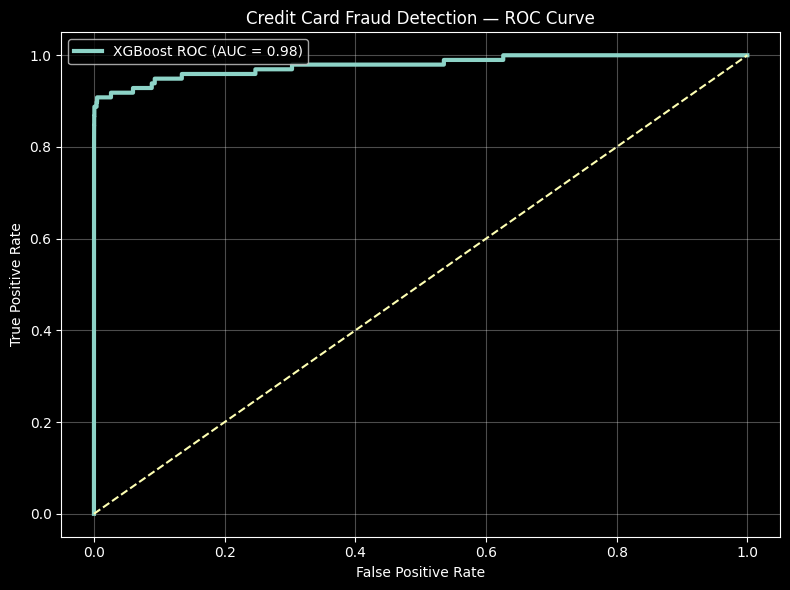

In [92]:
plt.style.use("dark_background")


y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=3, label=f'XGBoost ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], '--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Credit Card Fraud Detection — ROC Curve")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("roc.png", dpi=300)
plt.show()

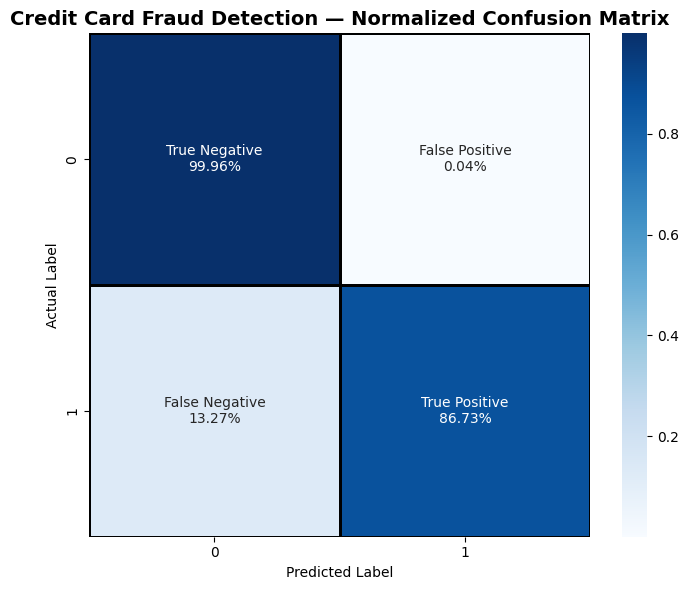

In [93]:
plt.style.use("default")
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

tn, fp, fn, tp = cm.ravel()

labels = np.array([
    [f"True Negative\n{cm_norm[0,0]*100:.2f}%", f"False Positive\n{cm_norm[0,1]*100:.2f}%"],
    [f"False Negative\n{cm_norm[1,0]*100:.2f}%", f"True Positive\n{cm_norm[1,1]*100:.2f}%"]
])

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=labels,
    fmt="",
    cmap="Blues",
    cbar=True,
    linewidths=2,
    linecolor="black"
)

plt.title("Credit Card Fraud Detection — Normalized Confusion Matrix",
          fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [78]:
import joblib

joblib.dump(model, "xgboost_fraud_model.pkl")
print("Model saved successfully!")


Model saved successfully!


In [79]:
loaded_model = joblib.load("xgboost_fraud_model.pkl")

test_pred = loaded_model.predict(X_test[:5])
print(test_pred)


[0 0 0 0 0]


In [80]:

sample = X_test.iloc[0:1]

prob = loaded_model.predict_proba(sample)[0][1]
print("Fraud Probability:", prob)

if prob >= 0.3:
    print(" Fraud Transaction")
else:
    print(" Normal Transaction")


Fraud Probability: 0.00011495343
 Normal Transaction
